In [ ]:
!pip3 install pyro-ppl

In [2]:
from preproc import preprocess_rsc15
dat, ind2val = preprocess_rsc15(limit_train = 10000, limit_test = 1000)

START load data
Loaded train set
	Events: 9999
	Sessions: 2337
	Items: 2843
	Span: 2014-04-01 / 2014-04-08

Loaded test set
	Events: 84
	Sessions: 24
	Items: 46
	Span: 2014-09-29 / 2014-09-30

END load data  0.030082000000000164 c /  0.027423620223999023 s


In [3]:
# Transform into sequence interaction object
from spotlight.interactions import Interactions, SequenceInteractions
dat_seq = {}
for name, df in dat.items():
    dat_seq[name] = Interactions(user_ids=df.SessionId_idx.values,
                item_ids=df.ItemId_idx.values,
                timestamps=df.Time.values).to_sequence()

In [4]:
import pyro.distributions as dist
from pyro import plate
from pyro.distributions import Categorical
import pyro

In [5]:
import torch.nn as nn
import torch

In [6]:
class LSTMVI(nn.Module):
    def __init__(self, num_items, emb_dim, use_cuda = True):
        super(LSTMVI, self).__init__()
        self.num_items = num_items
        self.emb_dim = emb_dim
        
        #self.V = pyro.param("item_mat", torch.rand(num_items, emb_dim)-0.5)
        
        
        ### LSTM
        self.lstm = nn.LSTM(batch_first=True,
                                input_size=self.emb_dim,
                                hidden_size=self.emb_dim)
        
        # Need to permute before and after LSTM because LSTM's batch_first is not supported...
        self.permute_for_lstm = lambda x: x.permute(1,0,2)
        self.permute_back_lstm = lambda x: x.permute(1,0,2)
        
        ### CUDA
        if use_cuda:
            # calling cuda() here will put all the parameters of
            # the encoder and decoder networks into gpu memory
            self.cuda()
        self.use_cuda = use_cuda
        

    
    def model(self, x):
        pyro.module("lstm", self.lstm)
        mu0 = torch.zeros(self.emb_dim).cuda()
        var0 = torch.diag(torch.ones(self.emb_dim)).cuda()*1

        muV = pyro.sample("muV", dist.MultivariateNormal(loc = mu0, covariance_matrix= var0))
        varU = varV = var0

        with plate("item_loop", self.num_items):
            V = pyro.sample(f"V", dist.MultivariateNormal(muV, varV))#.cuda()

        with pyro.plate("data", len(x), subsample_size=50) as ind:
            x_vecs = V[x[ind,]]
            
            z, _ = self.lstm(x_vecs)
            lprob = z.matmul(V.t())
            
            data = pyro.sample("obs_x", dist.Categorical(logits=lprob).to_event(2), obs = x[ind,])


In [22]:
print("Initializing model")
pyro.clear_param_store()
seq = dat_seq['train'].sequences
x = torch.from_numpy(seq[:500,6:]).long().cuda()

net = LSTMVI(len(ind2val["ItemId"]), emb_dim = 2)

Initializing model


In [23]:
#seq_cuda = torch.from_numpy(seq).long().cuda()

In [24]:
net.model(x)

In [25]:
from pyro.infer.mcmc import MCMC, NUTS
import pyro.optim as optim

In [35]:
nuts_kernel = NUTS(net.model, adapt_step_size=True)

hmc_posterior = MCMC(nuts_kernel, num_samples=100, warmup_steps=2) \
    .run(x)

Something is not working here. The model is only actually adjusting the weights some times... For example, only the second time the script runs in the same python session..

## Test samples
Visualize the samples for each item vector

In [39]:
from pyro.infer import EmpiricalMarginal, SVI, Trace_ELBO
import matplotlib.pyplot as plt
sites = ["V"]
hmc_empirical = EmpiricalMarginal(hmc_posterior, sites=sites)._get_samples_and_weights()[0].cpu().numpy()


(100, 1, 2843, 2)

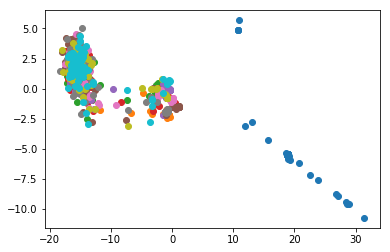

In [41]:
for i in range(10):
    coord = hmc_empirical.squeeze()[:,i,]
    plt.plot(coord[:,0],coord[:,1], "o")
    #plt.show()

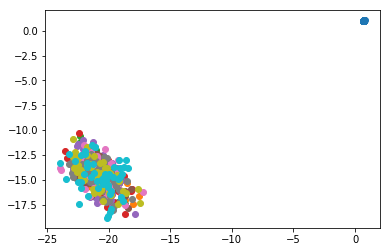

In [45]:
for i in range(10):
    coord = hmc_empirical.squeeze()[:,i,][50:]
    plt.plot(coord[:,0],coord[:,1], "o")
    #plt.show()

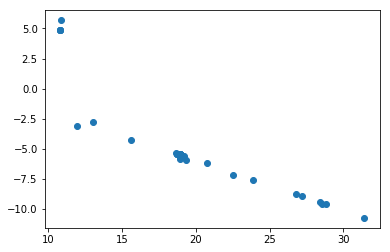

In [42]:
for i in range(1):
    coord = hmc_empirical.squeeze()[:,i,]
    plt.plot(coord[:,0],coord[:,1], "o")
    #plt.show()